# Fully Convolutional Neural Network Parameterizations

In this notebook, we'll demonstrate loading and evaluating one of our fully convolutional neural network (FCNN) parameterizations.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyqg
import json
import fsspec
from pyqg_parameterization_benchmarks.neural_networks import FCNNParameterization

%matplotlib inline
plt.rcParams.update({'font.size': 13})

## Load the FCNN and a dataset

In [4]:
param = FCNNParameterization('../models/fcnn_q_to_Sqtot1')

In [13]:
# Print out a summary of its architecture -- note the circular padding,
# which was particularly important for performance.
param.models[0]

FullyCNN(
  (0): Conv2d(2, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=circular)
  (1): ReLU()
  (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=circular)
  (4): ReLU()
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (7): ReLU()
  (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (10): ReLU()
  (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (13): ReLU()
  (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [5]:
# Datasets are hosted on globus as zarr files
def get_dataset(path, base_url="https://g-402b74.00888.8540.data.globus.org"):
    mapper = fsspec.get_mapper(f"{base_url}/{path}.zarr")
    return xr.open_zarr(mapper, consolidated=True)

In [8]:
# This dataset has the same distribution as the FCNN's training data, but is not something the FCNN has seen
# (we regenerated the dataset after pyqg changes which standardized/saved more diagnostics).
eddy_forcing1 = get_dataset('eddy/forcing1').isel(run=0).load()
eddy_forcing1['q_forcing_total'] = eddy_forcing1.dqdt_bar - eddy_forcing1.dqbar_dt

## Test it offline

In [10]:
preds = param.test_offline(eddy_forcing1)

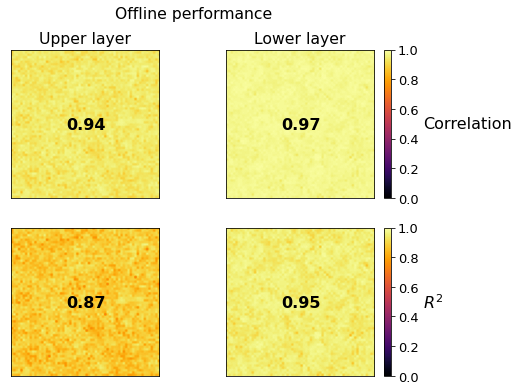

In [12]:
def imshow(arr):
    plt.imshow(arr, vmin=0, vmax=1, cmap='inferno')
    mean = arr.mean().data
    plt.text(32, 32, f"{mean:.2f}", color=('white' if mean<0.75 else 'black'),
             fontweight='bold', ha='center', va='center', fontsize=16)
    plt.xticks([]); plt.yticks([])
    
def colorbar(label):
    plt.colorbar().set_label(label, fontsize=16,rotation=0,ha='left',va='center')
    
fig = plt.figure(figsize=(7.6,6))
fig.suptitle("Offline performance")

for z in [0,1]:
    plt.subplot(2,2,z+1,title=f"{['Upper','Lower'][z]} layer")
    imshow(preds.q_forcing_total_spatial_correlation.isel(lev=z))
    if z: colorbar("Correlation")
    
for z in [0,1]:
    plt.subplot(2,2,z+3)
    imshow(preds.q_forcing_total_spatial_skill.isel(lev=z))
    if z: colorbar("$R^2$")

Compared to [our symbolic regression results](./notebooks/hybrid_symbolic.ipynb), the FCNN's offline performance is clearly stronger.

## Run it online (if you have a GPU)

This may take a while on most machines:

In [14]:
param_run = param.run_online(**json.loads(eddy_forcing1.pyqg_params))

INFO:  Logger initialized


KeyboardInterrupt: 